In [28]:
import pickle
import pandas as pd
import numpy as np
import re
import string

#Visualizations
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import seaborn as sns
import chart_studio
import chart_studio.plotly as py 
import chart_studio.tools as tls

from nltk import word_tokenize, pos_tag
#Natural Language Processing (NLP)
from gensim.models.ldamulticore import LdaMulticore
import gensim.corpora as corpora
from gensim.corpora import Dictionary
from gensim import matutils, models
import scipy.sparse
from sklearn.decomposition import LatentDirichletAllocation,NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

In [250]:
df=pd.read_csv('before_election.csv')

In [251]:
df

,date,state,tweet_cleaned,trump,biden,sid_sentiment,Subjectivity,Polarity,sid_overall,textblob_sentiment,sid_overall_sentiment,date.1
0,2020-10-15 00:00:01,Florida,elecciones florida biden dice que trump solo p...,1,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000000,0.00000,0.0000,Neutral,Neutral,2020-10-15 00:00:01
1,2020-10-15 00:00:20,Montana,islandgirlprv bradbeauregardj meidastouch bide...,0,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000000,0.00000,0.0000,Neutral,Neutral,2020-10-15 00:00:20
2,2020-10-15 00:00:22,California,censorship biden biden bidenemails bidenemail ...,0,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000000,0.00000,0.0000,Neutral,Neutral,2020-10-15 00:00:22
3,2020-10-15 00:00:25,Illinois,nypost censorship censored twitter manipulate ...,1,1,"{'neg': 0.186, 'neu': 0.644, 'pos': 0.17, 'com...",0.678571,-0.14881,-0.1027,Negative,Negative,2020-10-15 00:00:25
4,2020-10-15 00:00:57,Kentucky,fbi allegedly obtained hunter biden computer d...,0,1,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.100000,-0.10000,0.0000,Negative,Neutral,2020-10-15 00:00:57
...,...,...,...,...,...,...,...,...,...,...,...,...
243342,2020-11-03 23:59:27,NaN,appropriate since trump giving citizen big fuc...,1,0,"{'neg': 0.0, 'neu': 0.888, 'pos': 0.112, 'comp...",0.300000,0.25000,0.3400,Positive,Positive,2020-11-03 23:59:27
243343,2020-11-03 23:59:27,California,timobrien trump squatter tryna evade eviction,1,0,"{'neg': 0.375, 'neu': 0.625, 'pos': 0.0, 'comp...",0.000000,0.00000,-0.4588,Neutral,Negative,2020-11-03 23:59:27
243344,2020-11-03 23:59:31,California,bretbaier harris interviewed republican democr...,1,1,"{'neg': 0.053, 'neu': 0.635, 'pos': 0.312, 'co...",0.640000,0.23000,0.8689,Positive,Positive,2020-11-03 23:59:31
243345,2020-11-03 23:59:40,Pennsylvania,trump trump maga moreyears told red wave com,1,0,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000000,0.00000,0.0000,Neutral,Neutral,2020-11-03 23:59:40


In [16]:
def remove_name(twitter):   ### remove biden and trump names from the twitter
    twitter=re.sub(r'trump','',twitter)
    twitter=re.sub(r'biden','',twitter)
    twitter=re.sub(r'amp','', twitter)
    
    return twitter

In [17]:
df.dropna(how='any', subset=['tweet_cleaned'], inplace=True)
df

,state,tweet_cleaned
0,Florida,elecciones florida biden dice que trump solo p...
1,Montana,islandgirlprv bradbeauregardj meidastouch bide...
2,California,censorship biden biden bidenemails bidenemail ...
3,Illinois,nypost censorship censored twitter manipulate ...
4,Kentucky,fbi allegedly obtained hunter biden computer d...
...,...,...
243342,NaN,appropriate since trump giving citizen big fuc...
243343,California,timobrien trump squatter tryna evade eviction
243344,California,bretbaier harris interviewed republican democr...
243345,Pennsylvania,trump trump maga moreyears told red wave com


In [20]:
df['tweet']=df['tweet_cleaned'].apply(remove_name)
df=df[['state', 'tweet']]

In [22]:
df.to_csv('cleaned_before_election.csv')

## sklearn modeling process

In [6]:
## instantiate tfidf
no_features=5000  ## define number of total words 5000
tfidfv=TfidfVectorizer(max_df=0.9, min_df=2, max_features=no_features,stop_words='english') 
tfidf=tfidfv.fit_transform(df.tweet)
tfidf_feature_names=tfidfv.get_feature_names()

In [7]:
## instantiate countvectorizer
cv=CountVectorizer(max_df=0.9, min_df=2, max_features=no_features,stop_words='english')
c=cv.fit_transform(df.tweet)
cv_feature_names=cv.get_feature_names()

In [8]:
## Instantiate the NMF and LDA
no_topics=4
nmf=NMF(n_components=no_topics, random_state=1, alpha=0.1, l1_ratio=0.5, init='nndsvd')
lda=LatentDirichletAllocation(n_components=no_topics, max_iter=5, learning_method='online', learning_offset=50,random_state=0)

In [9]:
## run NMF and LDA
nmf_output=nmf.fit_transform(tfidf)
lda_output=lda.fit_transform(c)

In [10]:
## displaying and evaluating topics
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print ("Topic %d:" % (topic_idx))
        print (" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 20
display_topics(nmf, tfidf_feature_names, no_top_words)



Topic 0:
harris kamalaharris harristosaveamerica landslide voteblue tosaveamerica bluewave wtpblue blm votehimout wtpsenate harrislandslide voteearly resist electionday msnbc makeamericaunitedagain vetsforscience operationmaga negligenthomicide
Topic 1:
maga kag landslidevictory landslide gop rememberinnovember blue train moreyears tosaveamerica americafirst voteblue rally redwave pence votethemallout republican voteredtosaveamerica today votered
Topic 2:
debate presidentialdebate debatetonight tonight presidential meltdown final question said say debatenight moderator night time ispathetic fracking racist think que cnn
Topic 3:
covid democrat people like gop republican coronavirus say know win want year day need voting think time make country plan


In [11]:
display_topics(lda, cv_feature_names, no_top_words)

Topic 0:
covid harris maga gop landslide electionday voteblue voting coronavirus republican landslidevictory kamalaharris voted democrat virus blm cnn foxnews tosaveamerica msnbc
Topic 1:
win kag china news maga million medium money family twitter corruption child potus business night russia hunter bad story new
Topic 2:
like people know want make think country supporter votehimout let american lie life great say florida right way year care
Topic 3:
need debate rally going state today plan gop say potus tax voter said people year republican job death black day


In [16]:
# ###take too long to run--give up!!
# ## using GridSearch for LDA model
# search_params = {'n_components': [3, 4, 5, 6]}
# # Init Grid Search class
# model = GridSearchCV(lda, search_params)
# model.fit(c)
# best_lda_model = model.best_estimator_
# print("Best model's params: ", model.best_params_)
# print("Best log likelihood score: ", model.best_score_)
# print("Model perplexity: ", best_lda_model.perplexity(c))
# df_cv_results = pd.DataFrame(model.cv_results_)
# sns.pointplot(x="param_n_components", y="mean_test_score", hue="param_learning_decay", data=df_cv_results)

In [19]:
## LDA modeling (4 topics)
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda, c, cv, mds='tsne')


PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
3      269.562408 -124.803398       1        1  32.003670
2        1.782994 -295.079681       2        1  28.551441
1      220.811432 -343.832123       3        1  20.820685
0       50.533993  -76.050934       4        1  18.624204, topic_info=            Term          Freq         Total Category  logprob  loglift
939        covid  23601.000000  23601.000000  Default  30.0000  30.0000
1958      harris  22873.000000  22873.000000  Default  29.0000  29.0000
2669        maga  26070.000000  26070.000000  Default  28.0000  28.0000
2575        like  14188.000000  14188.000000  Default  27.0000  27.0000
1850         gop  12864.000000  12864.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
3700  republican   5275.744591   9394.215214   Topic4  -4.3441   1.1037
454         blue   2316.243774   2798.180777   Topic4  -5.1672   1.4917
1126    democrat   4051.049555   7760.165318   Topic4  -4.6082   1.0307
1052         day   2811.496303   8915.202681   Topic4  -4.9735   0.5267
3543       rally   2598.107835   9355.426748   Topic4  -5.0524   0.3995

[225 rows x 6 columns], token_table=      Topic      Freq          Term
term                               
29        3  0.999416       account
52        2  0.999581      actually
140       4  0.999754  americafirst
141       1  0.024047      american
141       2  0.975769      american
...     ...       ...           ...
4933      1  0.999610          word
4981      1  0.487698          year
4981      2  0.472780          year
4981      3  0.039467          year
4985      2  0.999521           yes

[279 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

In [20]:
lda4=pyLDAvis.sklearn.prepare(lda, c, cv, mds='tsne')
pyLDAvis.save_html(lda4, 'lda4.html')

In [23]:
# pyLDAvis.enable_notebook()
# pyLDAvis.sklearn.prepare(nmf, tfidf, tfidfv, mds='tsne')


In [27]:
import mglearn

C:\ProgramData\Anaconda3\lib\site-packages\mglearn\plot_pca.py:7: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='cache'", use "location='cache'" instead.
  memory = Memory(cachedir="cache")
C:\ProgramData\Anaconda3\lib\site-packages\mglearn\plot_nmf.py:7: DeprecationWarning: The 'cachedir' parameter has been deprecated in version 0.12 and will be removed in version 0.14.
You provided "cachedir='cache'", use "location='cache'" instead.
  memory = Memory(cachedir="cache")


In [25]:
# lda topics
sorting = np.argsort(lda.components_, axis=1)[:, ::-1]
feature_names=np.array(cv_feature_names)
mglearn.tools.print_topics(topics=range(no_topics), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=15)


topic 0       topic 1       topic 2       topic 3       
--------      --------      --------      --------      
covid         win           like          need          
harris        kag           people        debate        
maga          china         know          rally         
gop           news          want          going         
landslide     maga          make          state         
electionday   million       think         today         
voteblue      medium        country       plan          
voting        money         supporter     gop           
coronavirus   family        votehimout    say           
republican    twitter       let           potus         
landslidevictorycorruption    american      tax           
kamalaharris  child         lie           voter         
voted         potus         life          said          
democrat      business      great         people        
virus         night         say           year          




In [26]:
## nmf topics 
sorting = np.argsort(nmf.components_, axis=1)[:, ::-1]
feature_names=np.array(tfidf_feature_names)
mglearn.tools.print_topics(topics=range(no_topics), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=15)

topic 0       topic 1       topic 2       topic 3       
--------      --------      --------      --------      
harris        maga          debate        covid         
kamalaharris  kag           presidentialdebatedemocrat      
harristosaveamericalandslidevictorydebatetonight people        
landslide     landslide     tonight       like          
voteblue      gop           presidential  gop           
tosaveamerica rememberinnovembermeltdown      republican    
bluewave      blue          final         coronavirus   
wtpblue       train         question      say           
blm           moreyears     said          know          
votehimout    tosaveamerica say           win           
wtpsenate     americafirst  debatenight   want          
harrislandslidevoteblue      moderator     year          
voteearly     rally         night         day           
resist        redwave       time          need          
electionday   pence         ispathetic    voting        




### in summary NMF gives the better more distinct topics

## use nouns for topic modeling

In [28]:
def nouns(text):
    '''Given a string of text, tokenize the text and pull out only the nouns.'''
    is_noun = lambda pos: pos[:2] == 'NN'
    tokenized = word_tokenize(text)
    all_nouns = [word for (word, pos) in pos_tag(tokenized) if is_noun(pos)] 
    return ' '.join(all_nouns)

In [40]:
df['nouns']=df['tweet'].apply(nouns)  ## taking longer to go through the pos tags to extract noun data

In [41]:
# create the document-term matrix with only nouns using sklearn
cv=CountVectorizer()
cv_matrix=cv.fit_transform(df.nouns)
number_of_topics = 4  #Sklearn
model = LatentDirichletAllocation(n_components=number_of_topics) # random state for reproducibility
# Fit data to model
lda_noun=model.fit_transform(cv_matrix)
sorting = np.argsort(model.components_, axis=1)[:, ::-1]
feature_names=np.array(cv.get_feature_names())
mglearn.tools.print_topics(topics=range(number_of_topics), feature_names=feature_names, sorting=sorting, topics_per_chunk=5, n_words=50)


topic 0       topic 1       topic 2       topic 3       
--------      --------      --------      --------      
covid         debate        news          harris        
harris        maga          china         voteblue      
democrat      people        tax           kamalaharris  
coronavirus   year          fact          florida       
day           country       hunter        blm           
gop           gop           voter         child         
time          landslide     poll          pennsylvania  
supporter     presidentialdebatepeople        wtpblue       
plan          thing         medium        family        
virus         rally         corruption    que           
ballot        kag           question      debate        
word          time          care          texas         
penny         support       life          state         
death         man           potus         covid         
democracy     landslidevictorytwitter       resist        
harristosaveamericademocr

In [43]:
lda_nouns=pyLDAvis.sklearn.prepare(model,cv_matrix,cv,mds='tsne')
pyLDAvis.display(lda_nouns)
pyLDAvis.save_html(lda_nouns, 'lda_nouns.html')

In [65]:
## using Gensim 
id2word=Dictionary(df['nouns'].str.split())
corpus=[id2word.doc2bow(d) for d in df['nouns'].str.split()]
lda=LdaMulticore(corpus=corpus, num_topics=6, id2word=id2word, workers=12, passes=5)  ##gensim LDA
#lda_noun=pyLDAvis.gensim.prepare(lda,corpus,id2word)
#pyLDAvis.display(lda_noun)
#pyLDAvis.save_html(lda_plot,'gensim_noun.html')

In [58]:
pyLDAvis.save_html(lda_noun,'gensim_noun7.html')

In [42]:
from gensim.models.coherencemodel import CoherenceModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaMulticore(corpus=corpus, num_topics=num_topics, id2word=id2word, workers=12, passes=5)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

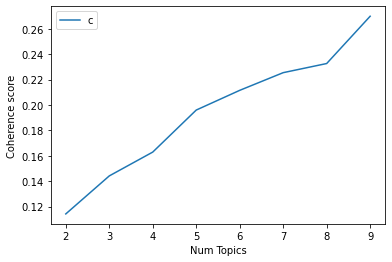

In [62]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df['nouns'].str.split(), start=2, limit=10)
# Show graph
import matplotlib.pyplot as plt
limit=10; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

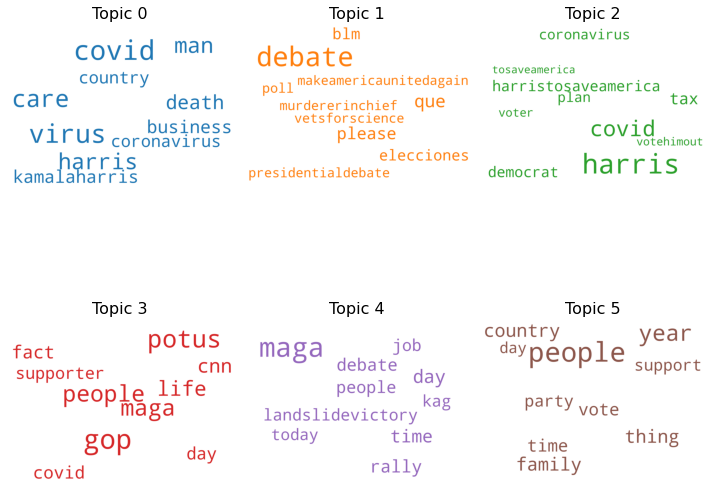

In [70]:
# show the wordcloud for the best modeling result  (pick 6 topics)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  
cloud = WordCloud(background_color='white',
                  width=2500,
                  height=1800,
                  max_words=20,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)
topics = lda.show_topics(formatted=False)

fig, axes = plt.subplots(2, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

## use nouns and adjectives for topic extraction 

In [28]:
## Topic Modeling (Nouns and Adjectives)
def nouns_adj(text):
    '''Given a string of text, tokenize the text and pull out only the nouns and adjectives.'''
    is_noun_adj = lambda pos: pos[:2] == 'NN' or pos[:2] == 'JJ'
    tokenized = word_tokenize(text)
    nouns_adj = [word for (word, pos) in pos_tag(tokenized) if is_noun_adj(pos)] 
    return ' '.join(nouns_adj)


In [29]:
df_adj_nouns=pd.DataFrame(df.tweet.apply(nouns_adj))  ## create the nouns_adj dataframe-takes longer to run


In [30]:
df_adj_nouns.to_csv('adj_nouns.csv')

In [64]:
df_adj_nouns.shape

(243346, 1)

In [54]:
## use sklearn library for the quick result
cvna=CountVectorizer()
data_cvna=cvna.fit_transform(df_adj_nouns.tweet)
number_of_topics = 5
model = LatentDirichletAllocation(n_components=number_of_topics) # random state for reproducibility
lda_noun_adj=model.fit_transform(data_cvna)

In [57]:
print('log_likelihood:', model.score(data_cvna))
print("Perplexity:", model.perplexity(data_cvna))

log_likelihood: -18218934.335334193
Perplexity: 5816.41097060026


In [37]:
#pickle.dump(model, open('adjn5.pkl', 'wb'))
#pickle.dump(data_cvna, open('data_cvna.pkl', 'wb'))

In [44]:
lda_adjn5=pyLDAvis.sklearn.prepare(model,data_cvna,cvna,mds='tsne')
pyLDAvis.display(lda_adjn5)
#pyLDAvis.save_html(lda_adjn5, 'adjn5.html')

In [218]:
# create the dataframe for the topics and keyword
keywords = np.array(cvna.get_feature_names())
topic_keywords = []
for topic_weights in model.components_:
    top_keyword_locs = (-topic_weights).argsort()[:20]
    topic_keywords.append(keywords.take(top_keyword_locs))
 
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['word_'+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

,word_0,word_1,word_2,word_3,word_4,word_5,word_6,word_7,word_8,word_9,word_10,word_11,word_12,word_13,word_14,word_15,word_16,word_17,word_18,word_19
Topic 0,china,que,tax,covid,elecciones,los,violence,oil,russia,con,country,por,woman,year,plan,stock,bank,para,party,account
Topic 1,harris,voteblue,harristosaveamerica,kamalaharris,tosaveamerica,state,people,please,time,landslide,year,blue,country,american,voter,harrislandslide,today,votehimout,maga,florida
Topic 2,covid,people,gop,republican,coronavirus,democrat,life,pandemic,potus,death,tax,plan,year,case,maga,virus,supporter,penny,new,mask
Topic 3,maga,family,hunter,corruption,medium,lie,china,people,landslidevictory,democrat,kag,black,year,racist,poll,man,business,corrupt,pennsylvania,care
Topic 4,debate,day,presidentialdebate,video,harris,twitter,watch,townhall,question,msnbc,wtpblue,minute,last,wtpsenate,tonight,maga,night,debatetonight,time,blm


In [215]:
topic_keywords

[array(['china', 'que', 'tax', 'covid', 'elecciones', 'los', 'violence',
        'oil', 'russia', 'con', 'country', 'por', 'woman', 'year', 'plan',
        'stock', 'bank', 'para', 'party', 'account'], dtype='<U68'),
 array(['harris', 'voteblue', 'harristosaveamerica', 'kamalaharris',
        'tosaveamerica', 'state', 'people', 'please', 'time', 'landslide',
        'year', 'blue', 'country', 'american', 'voter', 'harrislandslide',
        'today', 'votehimout', 'maga', 'florida'], dtype='<U68'),
 array(['covid', 'people', 'gop', 'republican', 'coronavirus', 'democrat',
        'life', 'pandemic', 'potus', 'death', 'tax', 'plan', 'year',
        'case', 'maga', 'virus', 'supporter', 'penny', 'new', 'mask'],
       dtype='<U68'),
 array(['maga', 'family', 'hunter', 'corruption', 'medium', 'lie', 'china',
        'people', 'landslidevictory', 'democrat', 'kag', 'black', 'year',
        'racist', 'poll', 'man', 'business', 'corrupt', 'pennsylvania',
        'care'], dtype='<U68'),
 array(

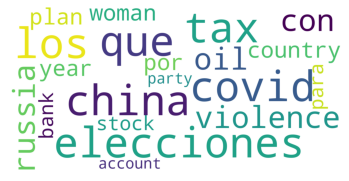

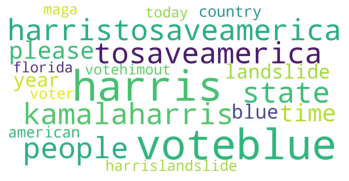

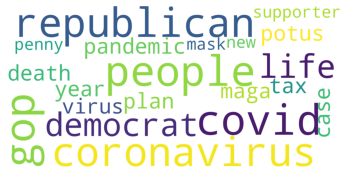

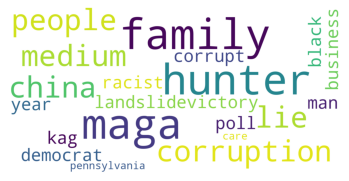

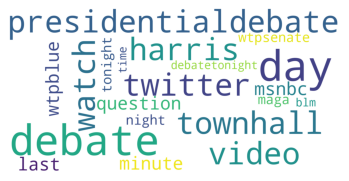

In [221]:
# create the wordcloud
from wordcloud import WordCloud
for index, row in df_topic_keywords.iterrows():
    words=[row.word_0, row.word_1,row.word_2,row.word_3,row.word_4,row.word_5,row.word_6,row.word_7,row.word_8,row.word_9,row.word_10,row.word_11,row.word_12, row.word_13,row.word_14,row.word_15, row.word_16,row.word_17,row.word_18,row.word_19]
    wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color="white").generate(' '.join(words))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()


In [222]:
## find the Dominant Topic of each tweet
lda_output =lda_noun_adj
topicnames = ["Topic" + str(i) for i in range(model.n_components)]
docnames = ["Tweet " + str(i) for i in range(len(df_adj_nouns))]
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic
# # Styling
def color_green(val):
    color = 'red' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
     weight = 700 if val > .1 else 400
     return 'font-weight: {weight}'.format(weight=weight)

# # Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics

,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
Tweet 0,0.960000,0.010000,0.010000,0.010000,0.010000,0
Tweet 1,0.040000,0.840000,0.040000,0.040000,0.040000,1
Tweet 2,0.050000,0.050000,0.050000,0.800000,0.050000,3
Tweet 3,0.290000,0.010000,0.010000,0.320000,0.360000,4
Tweet 4,0.030000,0.030000,0.030000,0.900000,0.030000,3
Tweet 5,0.270000,0.180000,0.510000,0.020000,0.020000,2
Tweet 6,0.020000,0.020000,0.020000,0.640000,0.300000,3
Tweet 7,0.020000,0.020000,0.020000,0.400000,0.550000,4
Tweet 8,0.020000,0.020000,0.020000,0.830000,0.120000,3
Tweet 9,0.070000,0.070000,0.070000,0.730000,0.070000,3


In [225]:
tweet_topic=pickle.load(open('tweet_topic.pkl', 'rb'))

In [226]:
#t=pd.concat([df, df_document_topic.set_index(df.index)], axis=1)  ## merge the the original tweets data with the assigned topics
#t.to_pickle("tweet_topic.pkl")  

In [227]:
tweet_topic

,state,tweet,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
0,Florida,elecciones florida dice que solo preocupa po...,0.96,0.01,0.01,0.01,0.01,0
1,Montana,islandgirlprv bradbeauregardj meidastouch mad...,0.04,0.84,0.04,0.04,0.04,1
2,California,censorship emails email corruption,0.05,0.05,0.05,0.80,0.05,3
3,Illinois,nypost censorship censored twitter manipulate ...,0.29,0.01,0.01,0.32,0.36,4
4,Kentucky,fbi allegedly obtained hunter computer data u...,0.03,0.03,0.03,0.90,0.03,3
...,...,...,...,...,...,...,...,...
243342,NaN,appropriate since giving citizen big fuckyou ...,0.02,0.02,0.02,0.92,0.02,3
243343,California,timobrien squatter tryna evade eviction,0.04,0.04,0.84,0.04,0.04,2
243344,California,bretbaier harris interviewed republican democr...,0.01,0.95,0.01,0.01,0.01,1
243345,Pennsylvania,maga moreyears told red wave com,0.11,0.37,0.03,0.45,0.03,3


In [95]:
# import the original dataframe with the 'trump', 'biden' assigned and polarity sentiment
db=pd.read_csv('before_election.csv')
db.dropna(subset=['tweet_cleaned'],axis=0, inplace=True)
db=db[['state', 'trump', 'biden', 'sid_overall_sentiment']]

In [111]:
## merge the topics with the sentiment data
data_summary=pd.concat([t, db], axis=1)
data_summary.sample(20)

,state,tweet,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic,state,trump,biden,sid_overall_sentiment
178703,North Carolina,absolutely horrific hear chief staff markmeado...,0.01,0.08,0.88,0.01,0.01,2,North Carolina,1,0,Negative
155755,New York,landslide emails harrislandslide,0.07,0.07,0.07,0.73,0.07,3,New York,1,0,Neutral
90754,California,drug lindsey graham taking show sign,0.03,0.03,0.86,0.03,0.03,2,California,0,1,Neutral
125563,District of Columbia,administration want short extension russia ne...,0.01,0.16,0.81,0.01,0.01,2,District of Columbia,1,0,Positive
208571,Washington,skiridr muellershewrote ransomeware hammer ho...,0.03,0.31,0.18,0.45,0.03,3,Washington,1,0,Neutral
188869,North Carolina,unlike putin belief science wearamask,0.04,0.04,0.84,0.04,0.04,2,North Carolina,1,0,Neutral
67729,New York,penguinukbooks please read book paradise hell ...,0.01,0.01,0.71,0.25,0.01,2,New York,1,1,Negative
19154,Florida,stay home need anymore win without,0.05,0.39,0.05,0.05,0.46,4,Florida,0,1,Positive
221079,Kentucky,asoldiersvoice dancrenshawtx oath mean anythin...,0.11,0.01,0.62,0.24,0.01,2,Kentucky,1,0,Positive
125753,Kentucky,matter plan democracy exist without free flow ...,0.01,0.01,0.20,0.63,0.14,3,Kentucky,1,1,Negative


In [244]:
## topics -sentiment
topic_sentiment=data_summary.groupby(['dominant_topic','sid_overall_sentiment'])['sid_overall_sentiment'].count().to_frame()
topic_sentiment

sid_overall_sentiment
dominant_topic sid_overall_sentiment                       
0              Negative                                4892
               Neutral                                14218
               Positive                                4497
1              Negative                               11606
               Neutral                                17832
               Positive                               19901
2              Negative                               28925
               Neutral                                12735
               Positive                               25386
3              Negative                               21675
               Neutral                                16770
               Positive                               21052
4              Negative                               12789
               Neutral                                14154
               Positive                               16914

In [4]:
topic=[0,1,2,3,4]
polarity=['Neutral', 'Positive', 'Negative', 'Negative', 'Positive']
dts=pd.DataFrame(list(zip(topic, polarity)), columns=['topic', 'dominant_polarity'])
dts

,topic,dominant_polarity
0,0,Neutral
1,1,Positive
2,2,Negative
3,3,Negative
4,4,Positive


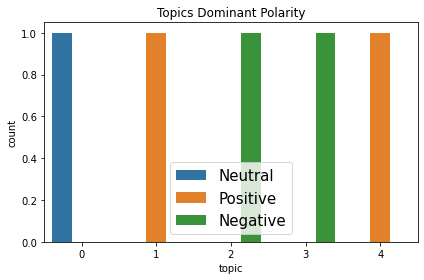

In [27]:
ax=plt.axes()
sns.countplot(x='topic', data=dts, hue='dominant_polarity')
ax.set_title('Topics Dominant Polarity')
ax.legend(fontsize=15)
plt.tight_layout()
plt.show()


In [83]:
t

,state,tweet,Topic0,Topic1,Topic2,Topic3,Topic4,dominant_topic
0,Florida,elecciones florida dice que solo preocupa po...,0.96,0.01,0.01,0.01,0.01,0
1,Montana,islandgirlprv bradbeauregardj meidastouch mad...,0.04,0.84,0.04,0.04,0.04,1
2,California,censorship emails email corruption,0.05,0.05,0.05,0.80,0.05,3
3,Illinois,nypost censorship censored twitter manipulate ...,0.29,0.01,0.01,0.32,0.36,4
4,Kentucky,fbi allegedly obtained hunter computer data u...,0.03,0.03,0.03,0.90,0.03,3
...,...,...,...,...,...,...,...,...
243342,NaN,appropriate since giving citizen big fuckyou ...,0.02,0.02,0.02,0.92,0.02,3
243343,California,timobrien squatter tryna evade eviction,0.04,0.04,0.84,0.04,0.04,2
243344,California,bretbaier harris interviewed republican democr...,0.01,0.95,0.01,0.01,0.01,1
243345,Pennsylvania,maga moreyears told red wave com,0.11,0.37,0.03,0.45,0.03,3


Text(0.5, 1.0, 'Trump-mentioned tweets topics breakdown')

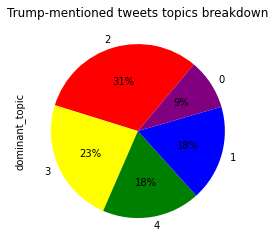

In [115]:
## pie plot
trump['dominant_topic'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['red', 'yellow', 'green', 'blue', 'purple'], startangle=50)
plt.title('Trump-mentioned tweets topics breakdown')

Text(0.5, 1.0, 'biden-mentioned tweets topics breakdown')

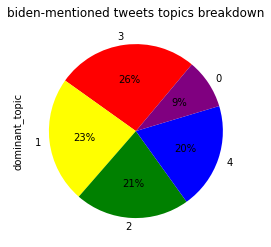

In [116]:
biden=data_summary[data_summary.biden==1]
biden['dominant_topic'].value_counts().plot(kind='pie', autopct='%1.0f%%', colors=['red', 'yellow', 'green', 'blue', 'purple'], startangle=50)
plt.title('biden-mentioned tweets topics breakdown')

In [248]:
df_all=data_summary.dropna()
df_all.to_csv('topic_sentiment_state.csv')

In [192]:
states=['California', 'Florida', 'New York', 'Texas']  #define states list to include 4 states

In [231]:
## groupby state to find out the topics for each state-- drop the data without the state
summary_state=data_summary.dropna()
ss=summary_state[['state', 'dominant_topic']]
ss=ss.iloc[:, 1:]
df4=ss[ss.state.isin(states)]
df4

,state,dominant_topic
0,Florida,0
2,California,3
5,Florida,2
7,California,4
9,California,3
...,...,...
243338,Florida,2
243340,California,2
243341,New York,0
243343,California,2


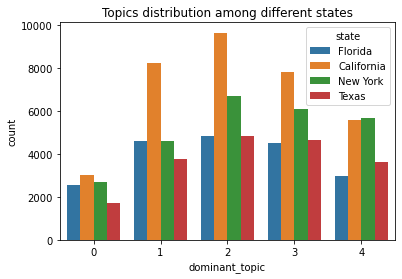

In [196]:
## topic number breakdown 
ax=plt.axes()
sns.countplot(x='dominant_topic', data=df4, hue='state')
ax.set_title('Topics distribution among different states')
plt.show()

In [114]:
## Group by and find the dominant topics for each candidate
trump=data_summary[data_summary.trump==1]
trump.groupby('dominant_topic').count()

,state,tweet,Topic0,Topic1,Topic2,Topic3,Topic4,state,trump,biden,sid_overall_sentiment
dominant_topic,,,,,,,,,,,
0,13570,16403,16403,16403,16403,16403,16403,13570,16403,16403,16403
1,26479,31131,31131,31131,31131,31131,31131,26479,31131,31131,31131
2,45409,54715,54715,54715,54715,54715,54715,45409,54715,54715,54715
3,33382,40675,40675,40675,40675,40675,40675,33382,40675,40675,40675
4,27496,31851,31851,31851,31851,31851,31851,27496,31851,31851,31851


## Gensim 

In [39]:
# using Genism model
id2word=Dictionary(df_adj_nouns['tweet'].str.split())
corpus=[id2word.doc2bow(doc) for doc in df_adj_nouns['tweet'].str.split()]

In [40]:
filename='id2word.sav'
corpus1='corpus.sav'
pickle.dump(id2word, open(filename, 'wb'))
pickle.dump(corpus, open(corpus1, 'wb'))

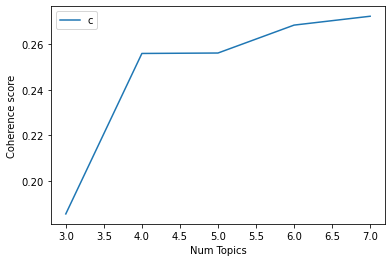

In [47]:
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=df_adj_nouns['tweet'].str.split(), start=3, limit=8)
# Show graph
import matplotlib.pyplot as plt
limit=8; start=3; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [52]:
model=LdaMulticore(corpus=corpus, num_topics=5, id2word=id2word, workers=12, passes=5)  # pick the topic number as 6

In [53]:
adjn_5=pyLDAvis.gensim.prepare(model,corpus,id2word) #if topic number 5, two potics are overlapping
pyLDAvis.display(adjn_5)

## In summary: Gensim topic 5 & 6 have overlapping words. So Sklearn has 5 distinct topics will be used 

In [49]:
model=LdaMulticore(corpus=corpus, num_topics=6, id2word=id2word, workers=12, passes=5)  # pick the topic number as 6
adjn6=pyLDAvis.gensim.prepare(model,corpus,id2word) #if topic number 5, two potics are overlapping
pyLDAvis.display(adjn6)
pyLDAvis.save_html(lda_plot, 'adj_noun_6.html')